In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import glob as gb
import cv2
import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
code = {'Tomato___Bacterial_spot':0 ,'Tomato___Early_blight':1,'Tomato___Late_blight':2,'Tomato___Leaf_Mold':3,'Tomato___Septoria_leaf_spot':4,'Tomato___Spider_mites Two-spotted_spider_mite':5 , 'Tomato___Target_Spot':6 ,'Tomato___Tomato_Yellow_Leaf_Curl_Virus':7 , 'Tomato___Tomato_mosaic_virus':8 ,'Tomato___healthy':9  }

def getcode(n) : 
    for x , y in code.items() : 
        if n == y : 
            return x

In [4]:
path='/kaggle/input/plantvillage-dataset/color/'

In [5]:
s = 128
X = []
y = []
for folder in  os.listdir(path) :
    if(folder.startswith("Tomato")):
        files = gb.glob(pathname= str( path  + folder + '/*.JPG'))
        print(folder)
        for file in files: 
            image = cv2.imread(file)
            image_array = cv2.resize(image , (s,s))
            image=image/255
            X.append(list(image_array))
            y.append(folder)

print(f'we have {len(X)} items in X ')

Tomato___Late_blight
Tomato___healthy
Tomato___Early_blight
Tomato___Septoria_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Bacterial_spot
Tomato___Target_Spot
Tomato___Tomato_mosaic_virus
Tomato___Leaf_Mold
Tomato___Spider_mites Two-spotted_spider_mite
we have 18006 items in X 


In [6]:
y = np.array(y).reshape(-1, 1)

In [7]:
from sklearn.preprocessing import OneHotEncoder
one=OneHotEncoder()
y=one.fit_transform(y).toarray()

In [8]:
X = np.array(X)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  shuffle=True, random_state=42)

In [10]:
del X
del y

In [11]:
from sklearn.model_selection import train_test_split
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5,  shuffle=True, random_state=42)

In [12]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size, self.patch_size, 1),
            strides=(1, self.patch_size, self.patch_size, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


In [13]:
class External_Attention(keras.layers.Layer):
    
  def __init__(self,dim, num_heads=2, dim_coefficient=4, attention_dropout=0, projection_dropout=0):
    super(External_Attention,self).__init__()
    self.dim=dim
    self.num_heads=num_heads
    self.dim_coefficient=dim_coefficient
    self.attention_dropout=attention_dropout
    self.projection_dropout=projection_dropout
   

    self.num_heads = self.num_heads * self.dim_coefficient
    self.dense1 = layers.Dense(self.dim * self.dim_coefficient)
    self.dense2 = layers.Dense(self.dim // self.dim_coefficient)
    self.softmax = layers.Softmax(axis=2)
    self.drop1 = layers.Dropout(self.attention_dropout)
    self.dense3 = layers.Dense(dim * dim_coefficient // num_heads)
    self.dense4 = layers.Dense(self.num_heads)
    self.drop3= layers.Dropout(self.projection_dropout)
    def call(self,inputs):
      _, num_patch, channel = inputs.shape
      x = self.dense1(inputs)
      x = tf.reshape(x, shape=(-1, num_patch, self.num_heads, self.dim * self.dim_coefficient // self.num_heads))
      x =  tf.transpose(x, perm=[0, 2, 1, 3])
      x = self.dense2(x)
      x = self.softmax(x)
      x = x / (1e-9 + tf.reduce_sum(x, axis=-1, keepdims=True))
      x = self.drop1(x)
      x = self.dense3(x)
      x = tf.transpose(x, perm=[0, 2, 1, 3])
      x = tf.reshape(x, [-1, num_patch, self.dim * self.dim_coefficient])
      x = self.dense4(x)
      x = self.drop3(x)
      return x
  

In [14]:
class Mlp(keras.layers.Layer):
  def __init__(self,embedding_dim, mlp_dim, drop_rate=0.2):
    super(Mlp,self).__init__()

    self.dense1 = layers.Dense(mlp_dim, activation=tf.nn.gelu)
    self.drop1 = layers.Dropout(drop_rate)
    self.dense2 = layers.Dense(embedding_dim)
    self.drop2 = layers.Dropout(drop_rate)
  def call(self,inputs):
    x = self.dense1(inputs)
    x = self.drop1(x)
    x = self. dense2(x)
    x = self.drop2(x)

    return x 


In [15]:
class Transformer_Encoder(keras.layers.Layer):
  
  def __init__(self,embedding_dim,mlp_dim,dim_coefficient,attention_dropout,projection_dropout,attention_type="external_attention",num_heads=2):

    super(Transformer_Encoder,self).__init__()
    
    
    self.embedding_dim=embedding_dim
    self.mlp_dim=mlp_dim
    self.num_heads=num_heads
    self.dim_coefficient=dim_coefficient
    self.attention_dropout=attention_dropout
    self.projection_dropout=projection_dropout
    self.attention_type=attention_type
    
    self.layer_norm1=layers.LayerNormalization(epsilon=1e-5)
    self.layer_norm2=layers.LayerNormalization(epsilon=1e-5)

    if(self.attention_type == "external_attention"):
    
      self.atten_type = External_Attention(
          dim=self.embedding_dim,
          num_heads=self.num_heads,
          dim_coefficient=self.dim_coefficient,
          attention_dropout=self.attention_dropout,
          projection_dropout=self.projection_dropout,
      )
    elif(self.attention_type == "self_attention"):
        self.atten_type = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim, dropout=self.attention_dropout)
     
    self.mlp=Mlp(self.embedding_dim, self.mlp_dim)   
     
  def call(self,inputs,training=True):

    x = self.layer_norm1(inputs)
    if(self.attention_type == "external_attention"):
      x=self.atten_type(x)
    else:
      self.atten_type(x,x)

    x = layers.add([x, inputs])

    residual_2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = layers.add([x, residual_2])

    return x

In [16]:
class EANet(keras.layers.Layer):
  def __init__(self,num_transformer_blocks=8,embedding_dim=64,mlp_dim=64,num_heads=4,
               dim_coefficient=4,attention_dropout=.2,
               projection_dropout=.2,attention_type="external_attention",
               patch_size=2,num_patches=16,num_classes=1
               ):
    super(EANet,self).__init__()
    
    self.num_transformer_blocks=num_transformer_blocks
    
    self.embedding_dim=embedding_dim
    self.mlp_dim=mlp_dim
    
    self.num_heads=num_heads
    self.dim_coefficient=dim_coefficient
    self.attention_dropout=attention_dropout
    self.projection_dropout=projection_dropout
    
    self.attention_type=attention_type
    self.patch_size=patch_size
    
    self.num_patches=num_patches
    self.num_classes=num_classes

    self.patch_extract=PatchExtract(self.patch_size)
    self.patch_embedding=PatchEmbedding(self.num_patches, self.embedding_dim)

    self.glopAvg= layers.GlobalAvgPool1D()
    self.out=layers.Dense(self.num_classes, activation="softmax")

    self.layers=[]
    for _ in range(self.num_transformer_blocks):
      self.layers.append(
          Transformer_Encoder(self.embedding_dim,mlp_dim=self.mlp_dim,num_heads=self.num_heads,dim_coefficient=self.dim_coefficient,
            attention_dropout=self.attention_dropout,projection_dropout=self.projection_dropout,attention_type=self.attention_type)
      )

    

  def call(self,inputs,training=True):
    x = self.patch_extract(inputs)
    x = self.patch_embedding(x)

    for block in self.layers:

      x = block(x,training=training)

    x=self.glopAvg(x)
    x=self.out(x)  
    return x
  

In [17]:
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8
num_classes=10
attention_type="external_attention"
# Number of repetitions of the transformer layer


In [18]:
inputs=keras.layers.Input(shape=(128,128,3))
num_patches=(inputs.shape[1] // patch_size) ** 2
model=EANet(num_transformer_blocks=8,
              embedding_dim=embedding_dim,
              mlp_dim=mlp_dim,num_heads=num_heads,
              dim_coefficient=dim_coefficient,attention_dropout=attention_dropout,
              projection_dropout=projection_dropout,attention_type=attention_type,
              patch_size=patch_size,num_patches=num_patches,num_classes=num_classes)(inputs)
model=keras.Model(inputs=inputs,outputs=model)
model.summary()

2023-01-29 21:28:45.817807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 21:28:45.977731: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 21:28:45.978955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 21:28:45.980662: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
ea_net (EANet)               (None, 10)                332234    
Total params: 332,234
Trainable params: 332,234
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [19]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(),optimizer='adam',
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
)

In [20]:
model.load_weights("/kaggle/input/eanet-weights/model.h5")

In [ ]:


history = model.fit(X_train,y_train,validation_data=(X_valid,y_valid), 
                    epochs=50,callbacks=[callback],batch_size=128,
                    verbose=1 )

In [21]:
from tensorflow.keras.utils import to_categorical
y_pred = model.predict(X_test)
y_pred2= to_categorical(np.argmax(y_pred, axis=1), 10)

# Using it in AUC
y_pred1=(np.argmax(y_pred, axis=1))
y_test1=(np.argmax(y_test, axis=1))

2023-01-29 21:29:20.077280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [22]:
# check whether the model is best fit for the given problem and corresponding data , Evaluate the model on the test data
def evaluate_model(X_test , y_test):
    results = model.evaluate(X_test, y_test, batch_size=32)
    return results

In [23]:
# Computing the Accuracy Score  : ((TP + TN) / float(TP + TN + FP + FN))
def Accuracy(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    return AccScore

In [24]:
#Computing the Precision metric (Some times called Specificity): #(True Positives / float(True Positives + False Posivites))  
def macro_precision(y_test , y_pred):
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    return PrecisionScore

In [25]:
#Computing the Recall Score : (Some times called Sensitivity) (TP / float(TP + FN))   1 / 1+2  
def macro_recall(y_test , y_pred):
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    return  RecallScore

In [26]:
#Computing the F1 Score  : 2 * (precision * recall) / (precision + recall)
def macro_F1Score(y_test , y_pred):
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return F1Score

In [27]:
from sklearn.metrics import roc_auc_score

# Calculating Area under the curve
def AUC(actual_class, pred_class, average = "micro"):
    
    #Making a set of all the unique classes 
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #Making a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [28]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(X_test , y_test)) 
print("******************************")
print("Accuracy  : " , Accuracy(y_test , y_pred2)) 
print("******************************")
print("Precision Score is : " , macro_precision(y_test , y_pred2))
print("******************************")
print("Recall Scores is : " , macro_recall(y_test , y_pred2))
print("******************************")
print('F1 Score is : ', macro_F1Score(y_test , y_pred2))
print("******************************")
print('AUC Score is : ' , AUC(y_test1, y_pred1))

***** Model Evaluations Details ******** 

57/57 [==============================] - 4s 45ms/step - loss: 0.5316 - accuracy: 0.8501
Test loss, Test acc :  [0.5315518379211426, 0.8500832915306091]
******************************
Accuracy  :  0.8500832870627429
******************************
Precision Score is :  0.8465620185806296
******************************
Recall Scores is :  0.7915053623837048
******************************
F1 Score is :  0.8030564239977709
******************************
AUC Score is :  {0: 0.8443075021950506, 1: 0.7689401656141024, 2: 0.8968702015747002, 3: 0.7456019470725352, 4: 0.9504796768492805, 5: 0.898007031894665, 6: 0.8755169614628727, 7: 0.9645108178333464, 8: 0.932941498086386, 9: 0.9911800486618004}


In [29]:
def plot_roc_curve(y_test,y_pred):
    n_classes=10
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw=2
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
    plt.figure(figsize=(10, 10))
    plt.plot(fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,)

    plt.plot(fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

    colors = cycle(["aqua", "darkorange", "cornflowerblue",'#9e9e9e','#b19a7e','#CD5C5C','#DFFF00',
                   '#DE3163','#ff4d4d','#666600'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
           fpr[i],
           tpr[i],
           color=color,
           lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Some extension of Receiver operating characteristic to multiclass")
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

In [30]:
def Acc_Loss_Graph(history):
    # converting hsitory to dataframe
    pd.DataFrame(history.history)

    pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')

    pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [31]:
labels=np.array(["Class 0","Class 1","Class 2","Class 3","Class 4","Class 5","Class 6","Class 7","Class 8","Class 9"])
def Confusion_Matrix(y_test , y_pred):
    fig, ax = plt.subplots(figsize=(10,10))

    #cnf_matrix = confusion_matrix()
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,display_labels=labels,ax=ax,xticks_rotation='vertical'
                                                  ,cmap="Blues")

In [ ]:
#plt.style.use('Solarize_Light2')

In [ ]:
Acc_Loss_Graph(history)

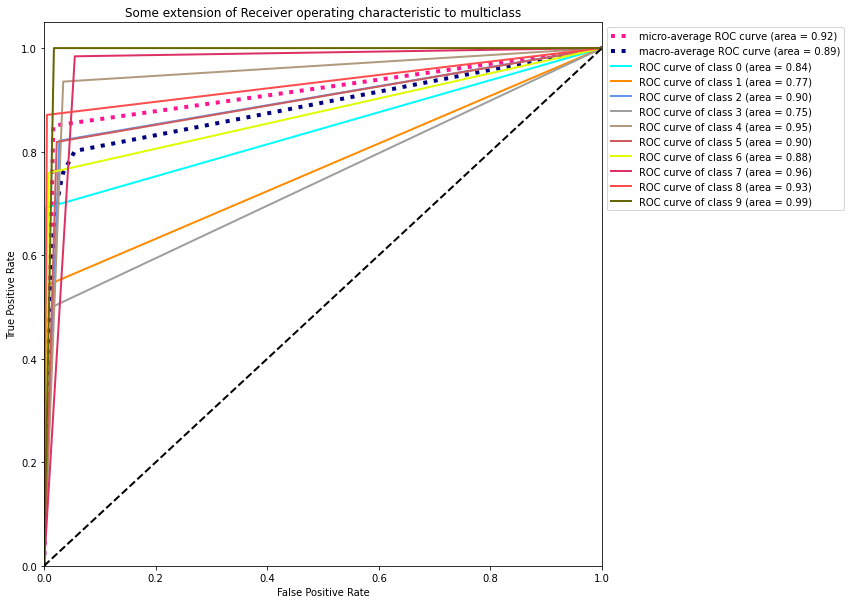

In [32]:
plot_roc_curve(y_test,y_pred2)

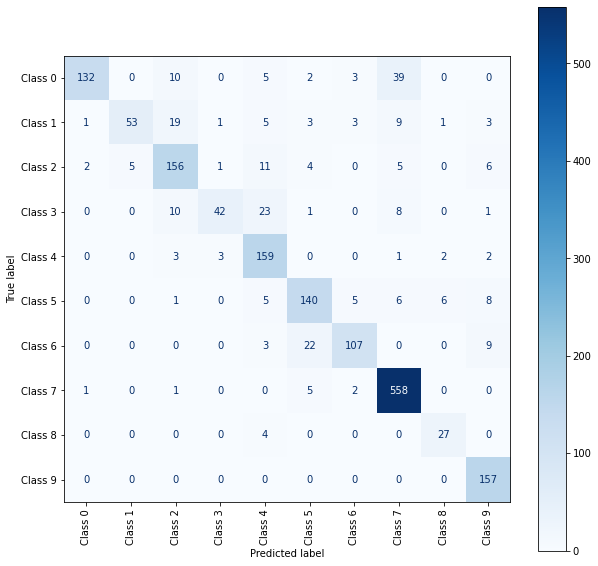

In [33]:
Confusion_Matrix(y_test1 , y_pred1)

In [ ]:
model.save_weights('/kaggle/working/model.h5')